# Estimation of Model Performance

In [96]:
import numpy as np
from keras.models import load_model
import pandas as pd
import pickle
from VideoGenerator import video2gif
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import plot_model
import warnings
warnings.simplefilter("ignore")

## Retrieve Data

In [2]:
def setting():
    path = {
        'model': 'model/seq_acu_95.h5',
        'test_x': 'model/seq_acu_95_test_x.pickle',
        'test_y': 'model/seq_acu_95_test_y.pickle',
        'train_x':'model/seq_acu_95_train_x.pickle',
        'train_y':'model/seq_acu_95_train_y.pickle',
        'le':'model/seq_acu_95_encoder.pickle'
    }
    return path

In [3]:
# Retrieve data and model
path = setting()
model = load_model(path['model'])

with open(path['le'], 'rb') as file:
    le = pickle.load(file)
with open(path['test_x'], 'rb') as file:
    test_x = pickle.load(file)
with open(path['test_y'], 'rb') as file:
    test_y = pickle.load(file)
    

### Error: Pickle Fails to write 2GB+ file

In [ ]:
with open('model/seq_acu_95_train_x.pickle', 'rb') as file:
    train_x = pickle.load(file)

In [ ]:
train_accuracy = model.evulate(train_x, train_y)

In [55]:
test_accuracy = model.evaluate(test_x, test_y)

3726/3726 [==============================] - 390s 105ms/step


[0.11311474671038453, 0.954106280097255]

In [ ]:
pred_y_train = model.predict(train_x)

In [97]:
pred_y = model.predict(test_x)

## 畫圖 Model Image

## 畫圖 Validation
- [Seaborn countplot](https://seaborn.pydata.org/generated/seaborn.countplot.html)


# Conclusions
1. The proposed concolutional neural network can predict the cell stages with test accuracy 95% based on nucleus morphology.
2. The proposed model can still predict stretching stage, which is defined by mitochondrial dynamic, with accuracy 93% solely based on nucleus morphology.
3. The speed of performance is 0.24 sec/image$_{200\times230}$

#### Testing Accuracy

3726


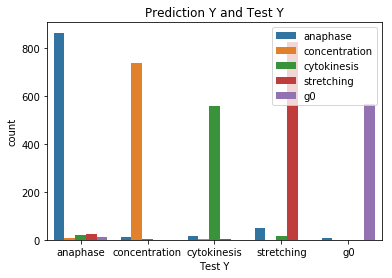

In [98]:
pred_y_arg = [np.argmax(i) for i in pred_y]
test_y_arg = [np.argmax(i) for i in test_y]

dy = pd.DataFrame.from_dict({
    'Prediction Y': np.array([le.inverse_transform(i) for i in pred_y_arg]),
    'Test Y': np.array([le.inverse_transform(i) for i in test_y_arg])
})

## Plotting
plt.figure()
ax = sns.countplot(x='Test Y', hue="Prediction Y", order=['anaphase', 'concentration', 'cytokinesis','stretching', 'g0'],hue_order=['anaphase', 'concentration', 'cytokinesis','stretching', 'g0'],data= dy)
plt.legend(loc='upper right')
plt.title('Prediction Y and Test Y')
plt.savefig('src_demo/error-validation_test_2.png', dpi=300)

##
print(len(test_y))

#### Training Accuracy

In [ ]:
pred_y_train_arg = [np.argmax(i) for i in pred_y_train]
train_y_arg = [np.argmax(i) for i in train_y]

dy = pd.DataFrame.from_dict({
    'Prediction Y': np.array([le.inverse_transform(i) for i in pred_y_train_arg]),
    'Train Y': np.array([le.inverse_transform(i) for i in train_y_arg])
})

## Plotting
plt.figure()
ax = sns.countplot(x='Train Y', hue="Prediction Y", hue_order=['anaphase', 'concentration', 'cytokinesis','stretching', 'g0'],data= dy)
plt.legend(loc='upper right')
plt.title('Prediction Y and Train Y')
plt.savefig('src_demo/error-validation_train.png', dpi=300)

##
print(len(train_y))

### Plot figure

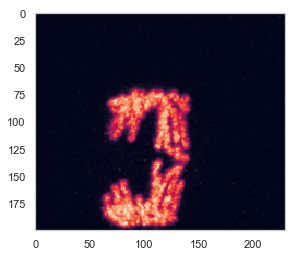

In [84]:
plt.imshow(test_x[0].reshape(200,230))
plt.grid('off')

## Predict an Image

In [30]:
from os.path import join
from skimage import io

In [25]:
# load data
img_folder = 'data/small-movie_duplicate_dual-only/'
dataset_full =  pd.read_csv(join(img_folder, 'DESCRIPTION_dual-only_full-classification.csv'))
dataset =  pd.read_csv(join(img_folder, 'DESCRIPTION_dual-only.csv'))

In [44]:
# Sample Image

i = 0

video = io.imread(join(img_folder, dataset_full['FileName_TIFF'][i]))

phases = {
    'anaphase_start': int(dataset_full['start anaphase'][i] - 1),
    'anaphase_end': int(dataset_full['start concentration'][i] -1),
   'concentration_start':int(dataset_full['start concentration'][i]-1), 
    'concentration_end': int(dataset_full['start cytokinesis'][i]-1),
    'cytokinesis_start':int(dataset_full['start cytokinesis'][i]-1), 
    'cytokinesis_end':int(dataset_full['start stretching'][i]-1), 
    'stretching_start':int(dataset_full['start stretching'][i]-1), 
    'stretching_end':int(dataset_full['complete division'][i]-1)
}

ch = {
    'nuc': 0,
    'mito': 1
}

def generate_obs_list(video, 
                     anaphase_start, anaphase_end,
                     concentration_start, concentration_end,
                     cytokinesis_start, cytokinesis_end,
                     stretching_start, stretching_end):
    frames = video.shape[0]
    obs_stages = ['g0'] * frames
    for i in range(anaphase_start,anaphase_end):
        obs_stages[i] = 'anaphase'
    
    for i in range(concentration_start,concentration_end):
        obs_stages[i]='concentration'
    
    for i in range(cytokinesis_start,cytokinesis_end):
        obs_stages[i]='cytokinesis'
        
    for i in range(stretching_start,stretching_end):
        obs_stages[i]='stretching'  
    
    return obs_stages

In [54]:
pred_stages = [predict(i) for i in video[:,60:260,60:290,0]]

CPU times: user 2min 30s, sys: 3.91 s, total: 2min 34s
Wall time: 47.2 s


In [59]:
obs_stages = generate_obs_list(video, **phases)

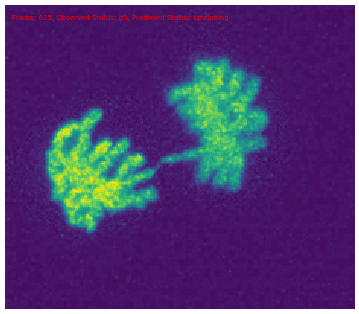

In [72]:
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import matplotlib.pyplot as plt

video2gif(video[:,60:260,60:290,0], obs_stages = obs_stages, pred_stages = pred_stages, figsize = (7,7), 
            dpi=50, interval=50, savepath='src_demo/PREDICTION_example_1.gif',fps=30)

In [91]:
dataset_full.head(2)

,Unnamed: 0,FileName_TIFF,concentration at division furrow,stretching,thinning before fission,spindle length (pixel),start anaphase,start concentration,start cytokinesis,start stretching,...,daughter nuclear intensity variance,daughter mitochondrial area 1,daughter mitochonrial area 2,daughter mitochondrial intensity 1,daughter mitochondrial intensity 2,daughter mitochondrial area variance,daughter mitochondrial intensity variance,notes,coverage of duration,total recorded frame number
0,1,11302017_c10_dual_decon-normal.tif,y,y,n,584,74,270,404,509,...,0.035596,136360,137504,10350530,11236200,0.004177,0.041028,NaN,metaphase-division,616.0
1,2,11302017_c3_dual_decon-normal.tif,y,y,y,533,48,153,252,361,...,0.107124,179307,185906,10580725,9292270,0.018069,0.064834,NaN,metaphase-division,541.0


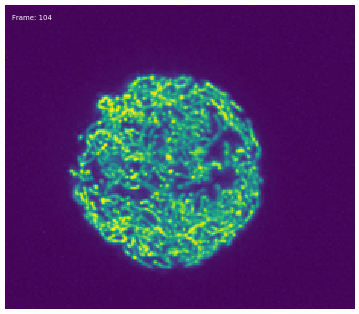

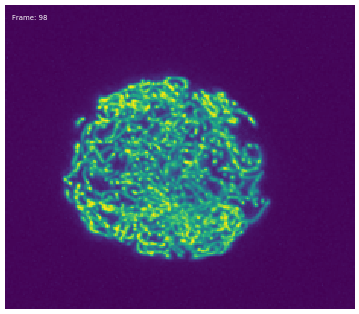

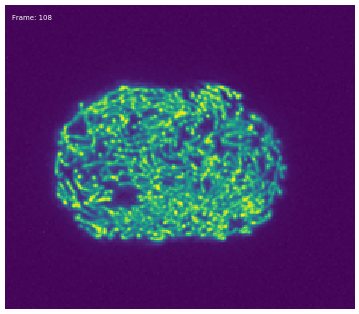

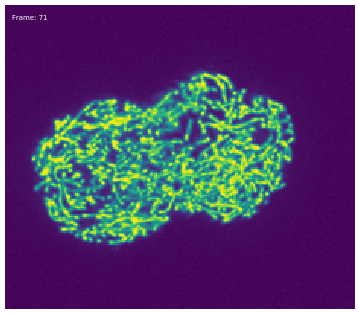

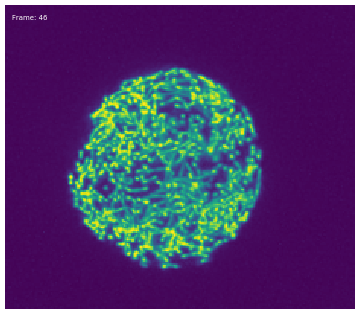

In [94]:
# INdex
i=1
anaphase_start= int(dataset_full['start anaphase'][i] - 1)
anaphase_end= int(dataset_full['start concentration'][i] -1)
concentration_start=int(dataset_full['start concentration'][i]-1)
concentration_end= int(dataset_full['start cytokinesis'][i]-1)
cytokinesis_start=int(dataset_full['start cytokinesis'][i]-1)
cytokinesis_end=int(dataset_full['start stretching'][i]-1)
stretching_start=int(dataset_full['start stretching'][i]-1)
stretching_end=int(dataset_full['complete division'][i]-1)



video2gif(video[anaphase_start:anaphase_end,60:260,60:290,1], obs_stages = [], pred_stages = [], figsize = (7,7), 
            dpi=50, interval=50, savepath='src_demo/DEMO_anaphase_mito.gif',fps=30)

video2gif(video[concentration_start:concentration_end,60:260,60:290,1], obs_stages = [], pred_stages = [], figsize = (7,7), 
            dpi=50, interval=50, savepath='src_demo/DEMO_concentration_mito.gif',fps=30)

video2gif(video[cytokinesis_start:cytokinesis_end,60:260,60:290,1], obs_stages = [], pred_stages = [], figsize = (7,7), 
            dpi=50, interval=50, savepath='src_demo/DEMO_cytokinesis_mito.gif',fps=30)

video2gif(video[stretching_start:stretching_end,60:260,60:290,1], obs_stages = [], pred_stages = [], figsize = (7,7), 
            dpi=50, interval=50, savepath='src_demo/DEMO_stretching_mito.gif',fps=30)

video2gif(video[0:47,60:260,60:290,1], obs_stages = [], pred_stages = [], figsize = (7,7), 
            dpi=50, interval=50, savepath='src_demo/DEMO_g0_mito.gif',fps=30)

In [83]:
anaphase_end

(269,)

In [70]:
def video2gif(imgs, obs_stages, pred_stages, figsize = (7,7), dpi=70, interval=50, savepath=None,fps=60):
    """
    Save Video to GIF
    Example: ani = PlayAnimation(video[:,60:260,60:290], obs_stages=[], pred_stages=[], savepath='test.gif', fps=60)
    """
    fig = plt.figure(figsize=figsize)
    fig.set_dpi(dpi)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    ax = fig.add_subplot(111)
    line = ax.imshow(imgs[0,:,:])
    time_text = ax.text(0.02, 0.95,'',transform=ax.transAxes, color='white') # Label frame number
    ax.set_axis_off()
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Remove Borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    fig.add_axes(ax)
    
    def init():
        line.set_data(imgs[0,:,:])
        time_text.set_text(str(0))
        return line, time_text
    
    def animate(i):
        line.set_data(imgs[i,:,:])
        try:
            time_text.set_text("Frame: {}, Observed Status: {}, Predicted Status: {}".format(i, obs_stages[i], pred_stages[i]))
            if obs_stages[i] == pred_stages[i]:
                time_text.set_color('white')
            else:
                time_text.set_color('red')
        except:
            time_text.set_text("Frame: {}".format(i))
            time_text.set_color('white')
        return line, time_text
    
    ani = animation.FuncAnimation(fig, animate, frames=imgs.shape[0], interval=interval, blit=True, init_func=init)
    
    if savepath != None:
        ani.save(savepath, writer='imagemagick', fps= fps)
    
    return ani 

In [53]:
video[:,60:260,60:290,0].shape

CPU times: user 20 µs, sys: 0 ns, total: 20 µs
Wall time: 24.1 µs


(616, 200, 230)

In [33]:
dataset_full.head(1)

,Unnamed: 0,FileName_TIFF,concentration at division furrow,stretching,thinning before fission,spindle length (pixel),start anaphase,start concentration,start cytokinesis,start stretching,...,daughter nuclear intensity variance,daughter mitochondrial area 1,daughter mitochonrial area 2,daughter mitochondrial intensity 1,daughter mitochondrial intensity 2,daughter mitochondrial area variance,daughter mitochondrial intensity variance,notes,coverage of duration,total recorded frame number
0,1,11302017_c10_dual_decon-normal.tif,y,y,n,584,74,270,404,509,...,0.035596,136360,137504,10350530,11236200,0.004177,0.041028,NaN,metaphase-division,616.0


In [ ]:
video

In [20]:
def predict(img, model= model, le=le):
    pred_y_vec = model.predict(np.array([[img]]))
    pred_y = le.inverse_transform(np.argmax(pred_y_vec))
    return pred_y

img = test_x[0].reshape(200,230)
predict(img, model, le)

'concentration'

# Accuracy of stretching process

In [99]:
pred_y_arg = [le.inverse_transform(np.argmax(i)) for i in pred_y]
test_y_arg = [le.inverse_transform(np.argmax(i)) for i in test_y]

## Calculate accuracy of stretching process

In [106]:
e = 0 
c = 0
for t, p in zip(test_y_arg, pred_y_arg):
    if t == 'stretching' and p != 'stretching':
        e +=1
    if t == 'stretching':
        c +=1
        
print('Accuracy of stretching is {}'.format((c-e)/c))

Accuracy of stretching is 0.9302587176602924


## Calculate error of stretching process

In [108]:
c_s = 0 
c_c = 0
s_s = 0
s_c = 0 
total = 0
for t, p in zip(test_y_arg, pred_y_arg):
    if t == 'stretching' and p == 'stretching':
        s_s +=1
    if t == 'stretching' and p == 'cytokinesis':
        s_c +=1
        
    if t == 'cytokinesis' and p == 'stretching':
        c_s +=1
    
    if t == 'cytokinesis' and p == 'cytokinesis':
        c_c +=1
    
    if t == 'cytokinesis' or t=='stretching':
        total +=1

In [110]:
print(s_s/total)
print(s_c/total)
print(c_s/total)
print(c_c/total)

0.5618206521739131
0.009510869565217392
0.001358695652173913
0.3797554347826087
